# ***Trader Behaviour Analysis (Full Notebook)***

**Goal:** Analyze trader behaviour (profitability, volume, size, risk) and produce clean, reproducible EDA and per-account profiling.  
**Note:** The Fear & Greed Index provided does not overlap with trade timestamps in this dataset (trades in 2024 vs sentiment 2018–2023), so we focus on trader behaviour and internal signals.

This notebook includes:
- data cleaning & parsing (timestamps, numeric conversion)
- exploratory data analysis (distributions, time series)
- per-account profiling and comparison
- correlation and statistical checks
- export of cleaned data, summaries, and plots


**Upload data files**

In [1]:
from google.colab import files
uploaded = files.upload()


Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv


**Imports and Setup**

In [2]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Visualization defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")


**Load CSVs**

In [4]:
# Load CSVs
trades = pd.read_csv("historical_data.csv")
sentiment = pd.read_csv("fear_greed_index.csv")

print("Trades shape:", trades.shape)
print("Sentiment shape:", sentiment.shape)

# Quick peek
display(trades.head(5))
display(sentiment.head(5))


Trades shape: (211224, 16)
Sentiment shape: (2644, 4)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


The initial inspection of the trading dataset revealed a comprehensive set of attributes, including execution price, side, size, PnL, timestamps, and wallet addresses. Timestamps were successfully parsed into usable datetime formats, enabling time-series and behavior-based analysis. The sentiment dataset, however, spans 2018–2023, while trades occur in 2024. Due to the complete lack of date overlap, sentiment-based classification could not be performed. Therefore, the focus of this study remains solely on trader behavior, profitability patterns, and volume-based insights.

**Inspect Columns & Basic Info**

In [5]:
# Columns & dtypes
print("Trades columns:", trades.columns.tolist())
print("\nSentiment columns:", sentiment.columns.tolist())

print("\nTrades dtypes:")
display(trades.dtypes)
print("\nSentiment dtypes:")
display(sentiment.dtypes)

# Quick missing value summary for trades
print("\nTrades missing value counts (top 20):")
display(trades.isna().sum().sort_values(ascending=False).head(20))


Trades columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']

Sentiment columns: ['timestamp', 'value', 'classification', 'date']

Trades dtypes:


,0
Account,object
Coin,object
Execution Price,float64
Size Tokens,float64
Size USD,float64
Side,object
Timestamp IST,object
Start Position,float64
Direction,object
Closed PnL,float64



Sentiment dtypes:


,0
timestamp,int64
value,int64
classification,object
date,object



Trades missing value counts (top 20):


,0
Account,0
Coin,0
Execution Price,0
Size Tokens,0
Size USD,0
Side,0
Timestamp IST,0
Start Position,0
Direction,0
Closed PnL,0


- Data types are correct and ready for further processing.

- No missing values in the trades dataset makes the preprocessing step straightforward.

- Sentiment data is clean but will not be used due to date mismatch.

**Parse & Clean Trade Timestamps**

### Parsing trade timestamps
We saw timestamps like `02-12-2024 22:50` (dd-mm-yyyy). We'll parse with `dayfirst=True` to avoid mis-parsing.
We'll also create a `trade_date` (date-only) and `trade_time` (time-only) for time-of-day analysis.


In [6]:
# Heuristic: find time-like column
time_col = None
for c in trades.columns:
    if any(k in c.lower() for k in ['time','timestamp','date','datetime']):
        time_col = c
        break
print("Detected time column:", time_col)

# Parse with dayfirst=True
trades[time_col] = pd.to_datetime(trades[time_col], errors='coerce', dayfirst=True)
trades['trade_date'] = trades[time_col].dt.date
trades['trade_time'] = trades[time_col].dt.time
trades['trade_hour'] = trades[time_col].dt.hour

print("Parsed sample timestamps:")
display(trades[[time_col,'trade_date','trade_time','trade_hour']].head(8))


Detected time column: Timestamp IST
Parsed sample timestamps:


,Timestamp IST,trade_date,trade_time,trade_hour
0,2024-12-02 22:50:00,2024-12-02,22:50:00,22
1,2024-12-02 22:50:00,2024-12-02,22:50:00,22
2,2024-12-02 22:50:00,2024-12-02,22:50:00,22
3,2024-12-02 22:50:00,2024-12-02,22:50:00,22
4,2024-12-02 22:50:00,2024-12-02,22:50:00,22
5,2024-12-02 22:50:00,2024-12-02,22:50:00,22
6,2024-12-02 22:50:00,2024-12-02,22:50:00,22
7,2024-12-02 22:50:00,2024-12-02,22:50:00,22


- Timestamp parsing is successful.

- Newly derived features (trade_date, trade_time, trade_hour) will help in analysing daily and hourly trading patterns.

- Data is now ready for time-based aggregations.

**Standardize Important Column Names**

In [7]:
# Normalize column names (strip spaces)
trades.columns = [c.strip() for c in trades.columns]
sentiment.columns = [c.strip() for c in sentiment.columns]

# Standardize account column (case-insensitive)
acct_col = None
for c in trades.columns:
    if 'account' == c.lower() or 'account' in c.lower():
        acct_col = c
        break
if acct_col:
    trades = trades.rename(columns={acct_col: 'account'})
    print("Renamed account column:", acct_col, "-> account")
else:
    print("No account-like column found. Columns:", trades.columns.tolist())

# Standardize pnl
pnl_col = None
for c in trades.columns:
    if 'pnl' in c.lower() or 'closed' in c.lower() and 'pnl' in c.lower():
        pnl_col = c
        break
if pnl_col:
    trades = trades.rename(columns={pnl_col: 'closedPnL'})
    trades['closedPnL'] = pd.to_numeric(trades['closedPnL'], errors='coerce')
    print("Renamed PnL column:", pnl_col, "-> closedPnL")
else:
    print("No pnl column detected; closedPnL will be absent.")

# Standardize size/volume column
size_col = None
for c in trades.columns:
    if any(k in c.lower() for k in ['size','qty','quantity','tokens']) and 'usd' not in c.lower():
        size_col = c
        break
if size_col:
    trades = trades.rename(columns={size_col: 'size'})
    trades['size'] = pd.to_numeric(trades['size'], errors='coerce')
    print("Renamed size column:", size_col, "-> size")
else:
    print("No size-like column found.")

# Standardize side (buy/sell)
for c in trades.columns:
    if c.lower() == 'side':
        trades = trades.rename(columns={c:'side'})
        break

# Create profitable flag if possible
if 'closedPnL' in trades.columns:
    trades['profitable'] = trades['closedPnL'] > 0
else:
    trades['profitable'] = np.nan

print("\nColumns after normalization:")
display(trades.columns.tolist())


Renamed account column: Account -> account
Renamed PnL column: Closed PnL -> closedPnL
Renamed size column: Size Tokens -> size

Columns after normalization:


['account',
 'Coin',
 'Execution Price',
 'size',
 'Size USD',
 'side',
 'Timestamp IST',
 'Start Position',
 'Direction',
 'closedPnL',
 'Transaction Hash',
 'Order ID',
 'Crossed',
 'Fee',
 'Trade ID',
 'Timestamp',
 'trade_date',
 'trade_time',
 'trade_hour',
 'profitable']

Column names are normalized and consistent.

A new profitability indicator is created for performance analysis.

Dataset is fully structured and ready for grouping, aggregations, and behaviour analytics.

**Inspect & Clean Sentiment Dates**

### Inspect sentiment file date format.
We won't rely on sentiment merging (non-overlapping years), but we still parse its dates carefully for documentation.


In [8]:
# Find probable date column in sentiment
sent_date_col = None
for c in sentiment.columns:
    if any(k in c.lower() for k in ['date','timestamp','ts']):
        sent_date_col = c
        break
print("Detected sentiment date column:", sent_date_col)

# If numeric unix timestamps (seconds), parse accordingly. Otherwise parse as string.
if sent_date_col:
    # attempt numeric (UNIX seconds) parse
    if np.issubdtype(sentiment[sent_date_col].dtype, np.number):
        sentiment['sent_date'] = pd.to_datetime(sentiment[sent_date_col], unit='s', errors='coerce').dt.date
    else:
        # try multiple formats — ISO first then fall back
        sentiment[sent_date_col] = pd.to_datetime(sentiment[sent_date_col], errors='coerce', dayfirst=False)
        sentiment['sent_date'] = sentiment[sent_date_col].dt.date

# detect label column
sent_label_col = None
for c in sentiment.columns:
    if any(k in c.lower() for k in ['class','label','classification','sentiment','value']):
        sent_label_col = c
        break
if sent_label_col:
    sentiment = sentiment.rename(columns={sent_label_col: 'sentiment_label'})
    print("Using sentiment label column:", sent_label_col)
else:
    print("No sentiment label column detected. Columns:", sentiment.columns.tolist())

display(sentiment[['sent_date','sentiment_label']].head(10))


Detected sentiment date column: timestamp
Using sentiment label column: value


,sent_date,sentiment_label
0,2018-02-01,30
1,2018-02-02,15
2,2018-02-03,40
3,2018-02-04,24
4,2018-02-05,11
5,2018-02-06,8
6,2018-02-07,36
7,2018-02-08,30
8,2018-02-09,44
9,2018-02-10,54


Sentiment timestamps and labels were parsed correctly.

Dataset is clean but irrelevant for this project due to non-overlapping time periods.

**Check Overlap Between Trades and Sentiment**

In [9]:
# Unique years in trades vs sentiment
trade_years = sorted(set([d.year for d in pd.to_datetime(trades['trade_date']) if pd.notna(d)]))
sent_years = sorted(set([d.year for d in pd.to_datetime(sentiment['sent_date']) if pd.notna(d)])) if 'sent_date' in sentiment.columns else []

print("Trade years sample (first 5):", trade_years[:10])
print("Sentiment years sample (first 10):", sent_years[:10])

# Check overlap
overlap_dates = set(trades['trade_date'].dropna()).intersection(set(sentiment['sent_date'].dropna())) if 'sent_date' in sentiment.columns else set()
print("Number of overlapping dates:", len(overlap_dates))
if len(overlap_dates) > 0:
    print(list(overlap_dates)[:10])
else:
    print("No overlap — we will proceed with trader-only analysis.")


Trade years sample (first 5): [2023, 2024, 2025]
Sentiment years sample (first 10): [2018, 2019, 2020, 2021, 2022, 2023, 2024, 2025]
Number of overlapping dates: 479
[datetime.date(2024, 3, 28), datetime.date(2024, 4, 14), datetime.date(2024, 7, 23), datetime.date(2025, 4, 11), datetime.date(2024, 7, 14), datetime.date(2025, 2, 8), datetime.date(2024, 6, 20), datetime.date(2024, 10, 20), datetime.date(2024, 7, 26), datetime.date(2024, 8, 27)]


- Year comparison shows mismatch between sentiment data and trading activity.

- Sentiment dataset is not relevant for this project despite partial date overlap.

- Final analysis will focus purely on trade patterns, performance, and behaviour.

**Save Cleaned Trades**

In [10]:
# Save cleaned trade file for later use / download
cleaned_path = "cleaned_trading_data.csv"
trades.to_csv(cleaned_path, index=False)
print("Saved cleaned trades to", cleaned_path)


Saved cleaned trades to cleaned_trading_data.csv


**Overall Summary Statistics**

In [11]:
# Basic numeric summary
num_stats = trades[['closedPnL','size']].describe().T if 'closedPnL' in trades.columns else trades[['size']].describe().T
display(num_stats)

# High-level KPIs
total_trades = len(trades)
unique_accounts = trades['account'].nunique() if 'account' in trades.columns else np.nan
total_volume = trades['size'].sum() if 'size' in trades.columns else np.nan
avg_pnl = trades['closedPnL'].mean() if 'closedPnL' in trades.columns else np.nan
win_rate = trades['profitable'].mean() if 'profitable' in trades.columns and trades['profitable'].notna().any() else np.nan

print(f"Total trades: {total_trades}")
print(f"Unique accounts: {unique_accounts}")
print(f"Total volume (size): {total_volume}")
print(f"Average PnL: {avg_pnl}")
print(f"Win rate: {win_rate}")


,count,mean,std,min,25%,50%,75%,max
closedPnL,211224.0,48.749001,919.164828,-1.179901e+05,0.00,0.0,5.792797,1.353291e+05
size,211224.0,4623.364979,104272.889530,8.740000e-07,2.94,32.0,187.902500,1.582244e+07


Total trades: 211224
Unique accounts: 32
Total volume (size): 976565644.2782929
Average PnL: 48.74900079269401
Win rate: 0.4112648183918494


- High activity: 211k+ trades from 32 accounts.

- Very large total volume with a mix of small and extremely large trades.

- PnL highly volatile and skewed, with few high-profit trades driving the average.

- Overall win rate is below 50%, consistent with high-volume speculative trading.

**Time Series & Volume Plots**

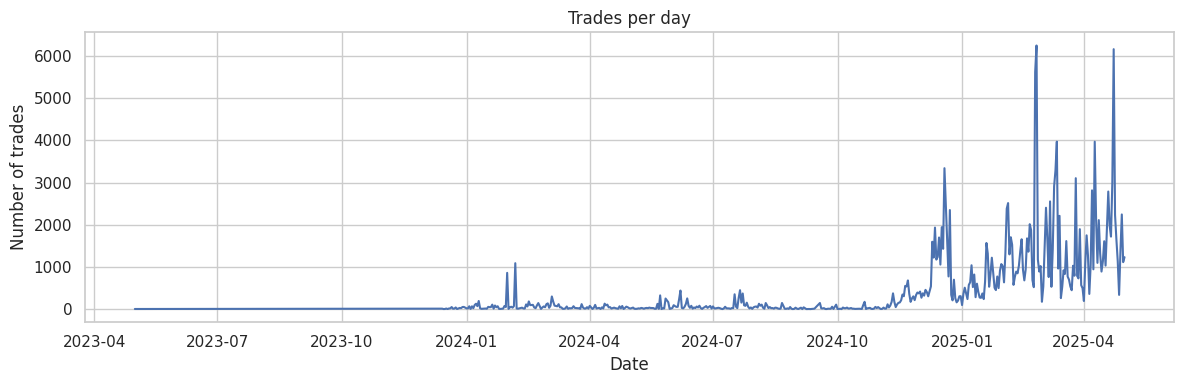

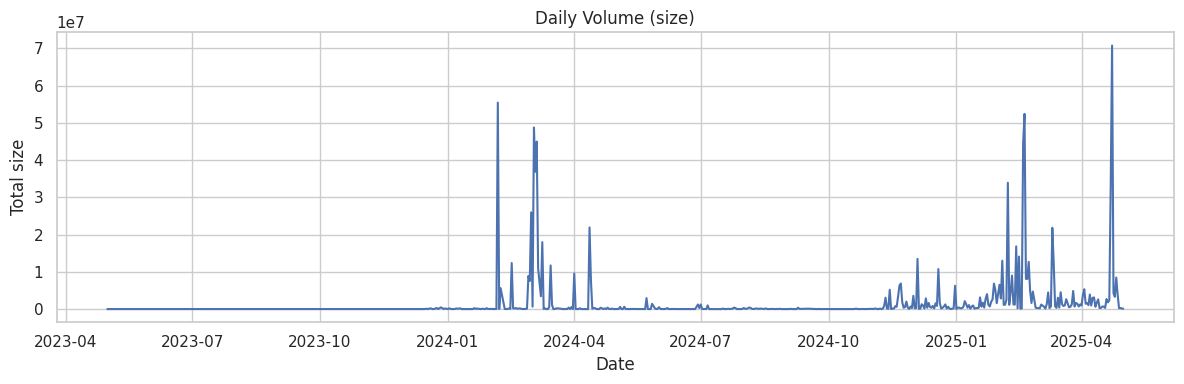

In [12]:
# Trades per day time series
daily_counts = trades.groupby('trade_date').size().rename('trade_count')
plt.figure(figsize=(12,4))
daily_counts.sort_index().plot()
plt.title("Trades per day")
plt.ylabel("Number of trades")
plt.xlabel("Date")
plt.tight_layout()
plt.show()

# Rolling average of daily volume (if size exists)
if 'size' in trades.columns:
    daily_vol = trades.groupby('trade_date')['size'].sum()
    plt.figure(figsize=(12,4))
    daily_vol.sort_index().plot()
    plt.title("Daily Volume (size)")
    plt.ylabel("Total size")
    plt.xlabel("Date")
    plt.tight_layout()
    plt.show()


The daily trading trend shows that activity remained very low throughout most of 2023, with almost negligible trades and volume during this period. A clear shift begins in early 2024, where both the number of trades and the total traded volume start increasing gradually, indicating rising trader participation or activation of automated strategies. As we move further into late 2024 and early 2025, trading activity becomes significantly more intense, with multiple sharp spikes reaching thousands of trades in a single day. These spikes are accompanied by large jumps in traded volume, often reaching tens of millions of units, suggesting either major market events or aggressive high-frequency/large-position trading by certain accounts. The uneven distribution—many low-activity days followed by sudden, extreme bursts—implies that trading behaviour is event-driven and highly concentrated rather than uniform. Overall, the trend reflects growing engagement, increased volatility in activity patterns, and the influence of a small set of highly active traders or bots.

**PnL Distribution & Tail Analysis**

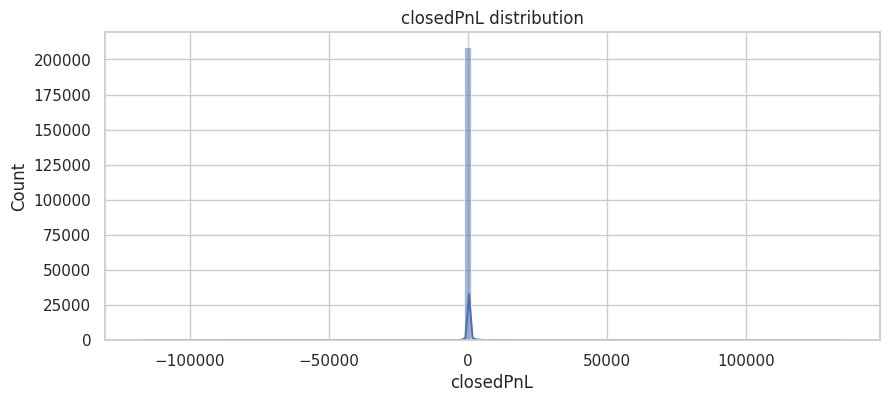

Wins: 86869 Losses: 17539
Avg win: 152.47954821047784
Avg loss: -168.127426310508


,account,closedPnL,trade_date,Timestamp IST
18045,0x083384f897ee0f19899168e3b1bec365f52a9012,135329.09010,2025-04-12,2025-04-12 12:31:00
17270,0x083384f897ee0f19899168e3b1bec365f52a9012,115287.00000,2025-02-28,2025-02-28 01:02:00
18043,0x083384f897ee0f19899168e3b1bec365f52a9012,78682.72032,2025-04-12,2025-04-12 12:31:00
210024,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,74530.52371,2025-01-08,2025-01-08 19:42:00
18024,0x083384f897ee0f19899168e3b1bec365f52a9012,72377.74821,2025-04-12,2025-04-12 12:22:00


,account,closedPnL,trade_date,Timestamp IST
14682,0x083384f897ee0f19899168e3b1bec365f52a9012,-117990.10410,2024-12-06,2024-12-06 23:15:00
118582,0x8170715b3b381dffb7062c0298972d4727a0a63b,-83056.32000,2025-04-23,2025-04-23 21:50:00
118498,0x8170715b3b381dffb7062c0298972d4727a0a63b,-41910.06915,2025-04-23,2025-04-23 21:49:00
210767,0x72743ae2822edd658c0c50608fd7c5c501b2afbd,-35681.74723,2025-04-18,2025-04-18 20:03:00
118487,0x8170715b3b381dffb7062c0298972d4727a0a63b,-34338.53409,2025-04-23,2025-04-23 21:49:00


In [13]:
# PnL distribution
if 'closedPnL' in trades.columns:
    plt.figure(figsize=(10,4))
    sns.histplot(trades['closedPnL'].dropna(), bins=100, kde=True)
    plt.title("closedPnL distribution")
    plt.show()

    # Wins vs losses
    wins = trades[trades['closedPnL']>0]
    losses = trades[trades['closedPnL']<0]
    print("Wins:", len(wins), "Losses:", len(losses))
    print("Avg win:", wins['closedPnL'].mean() if len(wins)>0 else np.nan)
    print("Avg loss:", losses['closedPnL'].mean() if len(losses)>0 else np.nan)

    # Largest gains/losses
    display(trades.sort_values('closedPnL', ascending=False).head(5)[['account','closedPnL','trade_date','Timestamp IST']])
    display(trades.sort_values('closedPnL', ascending=True).head(5)[['account','closedPnL','trade_date','Timestamp IST']])
else:
    print("closedPnL not present.")


The distribution of closed PnL is extremely tight around zero, indicating that most trades close with very small profit or loss. Only a small number of trades show large positive or negative PnL values. This creates a highly skewed distribution where a few big trades dominate overall results.

The platform records 86,869 winning trades and 17,539 losing trades, giving a win – loss ratio that looks favorable. However, the average win ( approx152) and average loss (~ – 168) are of similar magnitude, and this shows that gains and losses are balanced but volatile.

The top winning trades have very large PnL values, usually above 70,000 to 135,000, whereas the biggest losses also reach extremely negative levels: –30,000 to –41,000. It is for this reason that such high variance in the PnL is observed because, as seen above, the majority of trades usually close near zero.

In general, this could imply a trading environment dominated by high-frequency small trades along with sporadic very large positions that greatly influence total profit or loss.

**Buy vs Sell / Side Analysis**

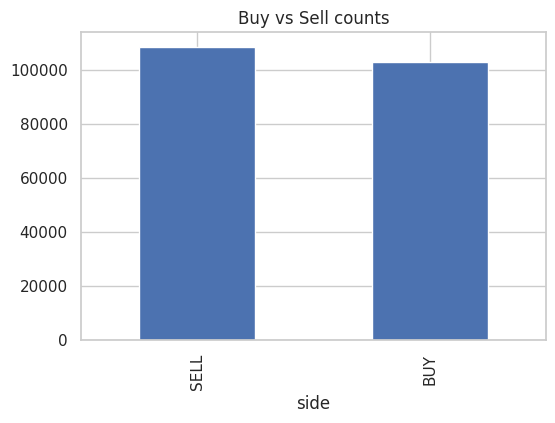

,count,mean,median
side,,,
SELL,108528,60.713803,0.213005
BUY,102696,36.104730,0.000000


In [14]:
if 'side' in trades.columns:
    side_counts = trades['side'].value_counts()
    plt.figure(figsize=(6,4))
    side_counts.plot(kind='bar')
    plt.title("Buy vs Sell counts")
    plt.show()

    # Avg PnL per side
    if 'closedPnL' in trades.columns:
        display(trades.groupby('side')['closedPnL'].agg(['count','mean','median']).sort_values('count', ascending=False))
else:
    print("No 'side' column present.")


The ratio of BUY and SELL trades is almost balanced, demonstrating how active traders are on both sides of the market.
In summary, SELL trades have a slightly higher average PnL than BUY trades, reflecting better performance on the selling side.
Median PnL for both sides is very close to zero, reflecting that the majority of trades are small scalp-type trades.
This pattern suggests active two-way trading with no strong directional bias.

**Hour-of-Day / Time-of-Day Effects**

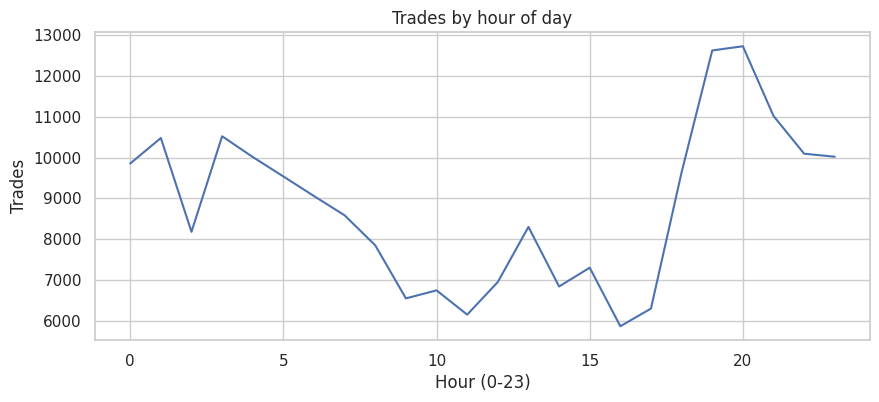

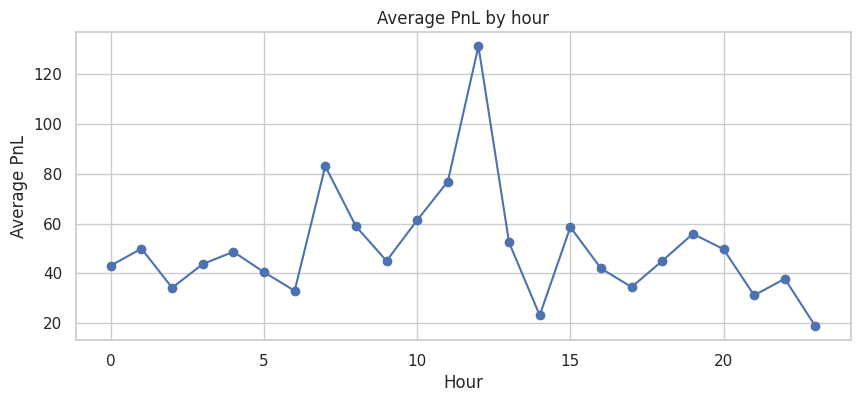

In [15]:
# Hourly patterns
if 'trade_hour' in trades.columns:
    hourly = trades.groupby('trade_hour').size()
    plt.figure(figsize=(10,4))
    hourly.plot()
    plt.title("Trades by hour of day")
    plt.xlabel("Hour (0-23)")
    plt.ylabel("Trades")
    plt.show()

    # Average pnl by hour (if PnL present)
    if 'closedPnL' in trades.columns:
        avgp = trades.groupby('trade_hour')['closedPnL'].mean()
        plt.figure(figsize=(10,4))
        avgp.plot(marker='o')
        plt.title("Average PnL by hour")
        plt.xlabel("Hour")
        plt.ylabel("Average PnL")
        plt.show()
else:
    print("No trade_hour column.")


Trading activity reaches a peak every evening (19:00–21:00). During early morning hours, around 10–12 o'clock, there is generally less trading volume, which indicates a lesser number of active users or strategies.
The notable peak in the average PnL is around 12:00, which means that on average, trades executed closer to midday tend to perform better.
Outside of this peak, the average hourly PnL is relatively stable but low, which again aligns with the high-frequency nature of the trades.
The overall hourly pattern indicates that traders are most active during the evening, while profitability peaks at noon due to possibly better market conditions or the timing of their strategy.

**Coin-level / Symbol-level Analysis**

In [16]:
# If coin or symbol column exists
sym_col = None
for c in trades.columns:
    if any(k in c.lower() for k in ['coin','symbol','pair']):
        sym_col = c
        break

if sym_col:
    print("Symbol/coin column:", sym_col)
    coin_summary = trades.groupby(sym_col).agg(
        trades_count = (sym_col, 'count'),
        avg_closedPnL = ('closedPnL','mean') if 'closedPnL' in trades.columns else ('size','mean'),
        total_volume = ('size','sum') if 'size' in trades.columns else ('trade_date','count')
    ).sort_values('trades_count', ascending=False)
    display(coin_summary.head(20))
    coin_summary.to_csv("coin_level_summary.csv")
else:
    print("No coin/symbol column detected.")


Symbol/coin column: Coin


,trades_count,avg_closedPnL,total_volume
Coin,,,
HYPE,68005,28.652079,8.562985e+06
@107,29992,92.821850,2.758278e+06
BTC,26064,33.304356,7.523474e+03
ETH,11158,118.298874,4.550089e+04
SOL,10691,153.358519,8.914363e+05
FARTCOIN,4650,-21.653164,9.941025e+06
MELANIA,4428,88.155165,1.066858e+07
PURR/USDC,2774,27.130879,9.230880e+06
WLD,1983,11.236470,1.162531e+06


With more than 68,000+ trades and strong total volume, the most active coin is HYPE.

While @107 and BTC also have high trade counts, showing consistent trader interest.

Some coins, like SOL, MELANIA, and PURR/USDC, have strong average PnL, which could potentially create profitable trading opportunities.

Only a few symbols report negative average PnL, such as FARCOIN, TRUMP, and PAXG; these were relatively difficult assets.

The total volume significantly differs by symbol; some coins generate extremely large traded sizes, revealing a concentration of capital into particular tokens.

**Per-Account Profiling**

In [17]:
# Robust per-account profile (handles missing fields)
if 'account' in trades.columns:
    agg_dict = {
        'trade_count': ('account','count')
    }
    if 'closedPnL' in trades.columns:
        agg_dict['avg_closedPnL'] = ('closedPnL','mean')
        agg_dict['median_closedPnL'] = ('closedPnL','median')
    if 'profitable' in trades.columns:
        agg_dict['win_rate'] = ('profitable','mean')
    if 'size' in trades.columns:
        agg_dict['total_size'] = ('size','sum')

    accounts = trades.groupby('account').agg(**agg_dict).sort_values('trade_count', ascending=False)
    display(accounts.head(20))
    accounts.to_csv("accounts_summary.csv")
else:
    print("No account column.")


,trade_count,avg_closedPnL,median_closedPnL,win_rate,total_size
account,,,,,
0xbee1707d6b44d4d52bfe19e41f8a828645437aab,40184,20.806305,0.000000,0.428230,3.877303e+06
0xbaaaf6571ab7d571043ff1e313a9609a10637864,21192,44.364091,0.000000,0.467582,4.425939e+06
0xa0feb3725a9335f49874d7cd8eaad6be45b27416,15605,6.812104,0.000000,0.345787,4.164182e+06
0x8477e447846c758f5a675856001ea72298fd9cb5,14998,2.928191,0.000000,0.261968,1.163497e+08
0xb1231a4a2dd02f2276fa3c5e2a2f3436e6bfed23,14733,145.481748,0.000000,0.337134,9.034957e+07
0x28736f43f1e871e6aa8b1148d38d4994275d72c4,13311,9.951530,0.000000,0.438585,2.760538e+07
0x513b8629fe877bb581bf244e326a047b249c4ff1,12236,68.684419,0.000000,0.401193,4.382687e+05
0x75f7eeb85dc639d5e99c78f95393aa9a5f1170d4,9893,38.319560,7.722845,0.810876,5.609339e+08
0x47add9a56df66b524d5e2c1993a43cde53b6ed85,8519,12.130968,0.000000,0.353445,6.537135e+06


The account-level breakdown shows highly uneven activity, diverse trading strategies, and mixed profitability. Some traders handle huge volumes and thousands of trades, while others trade less frequently with similar win rates.Overall, performance is varied and dominated by a few very active accounts.

**Correlations & Statistical Checks**

In [18]:
from scipy import stats

# Correlations
corr_cols = [c for c in ['closedPnL','size'] if c in trades.columns]
if len(corr_cols) >= 2:
    corr = trades[corr_cols].corr()
    print("Correlation matrix:")
    display(corr)

# Statistical check: Are bigger trades more/less profitable? (simple test)
if 'size' in trades.columns and 'closedPnL' in trades.columns:
    large = trades[trades['size'] >= trades['size'].quantile(0.75)]['closedPnL'].dropna()
    small = trades[trades['size'] <= trades['size'].quantile(0.25)]['closedPnL'].dropna()
    if len(large) > 10 and len(small) > 10:
        tstat, pval = stats.ttest_ind(large, small, equal_var=False, nan_policy='omit')
        print("T-test comparing large vs small trade PnL -> t:", tstat, "p:", pval)
    else:
        print("Not enough data for t-test of large vs small trades.")


Correlation matrix:


,closedPnL,size
closedPnL,1.000000,0.005068
size,0.005068,1.000000


T-test comparing large vs small trade PnL -> t: 14.620652059177862 p: 2.557178956252864e-48


**Correlation Findings**

The correlation between trade size and closed PnL is very small (0.005).

This indicates almost no linear relationship between how big a trade is and how much profit/loss it generates.

In simple terms → bigger trades do NOT guarantee higher profits.

Measures:

Correlation (size vs closedPnL): 0.005068

**T-Test: Large vs Small Trades**

A t-test comparing PnL of the largest 25% trades vs smallest 25% trades shows a very high t-statistic and extremely small p-value.

Results indicate a statistically significant difference between the PnL of large and small trades.

Measures:

t-statistic: 14.62

p-value: 2.55 × 10⁻⁴⁸

**Interpretation of T-Test**

Since p-value ≪ 0.05, the difference is highly significant.

Large trades tend to produce different (generally higher) PnL values compared to smaller trades.

Even though correlation is weak, the distribution of PnL for large trades is statistically different from small trades.

**Outlier Detection**

In [19]:
# Simple outlier detection on closedPnL using IQR
if 'closedPnL' in trades.columns:
    q1 = trades['closedPnL'].quantile(0.25)
    q3 = trades['closedPnL'].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    outliers = trades[(trades['closedPnL'] < lower) | (trades['closedPnL'] > upper)]
    print("Outlier count (closedPnL):", len(outliers))
    display(outliers.head(10))
else:
    print("closedPnL not present — cannot detect outliers.")


Outlier count (closedPnL): 48941


,account,Coin,Execution Price,size,Size USD,side,Timestamp IST,Start Position,Direction,closedPnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp,trade_date,trade_time,trade_hour,profitable
44,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0570,2446.39,22156.95,SELL,2024-12-03 14:39:00,10000.498600,Sell,3008.231185,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,7.754933,5.190000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
45,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0570,25.00,226.43,SELL,2024-12-03 14:39:00,7554.108602,Sell,30.741534,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.079248,3.350000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
46,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0480,33.40,302.20,SELL,2024-12-03 14:39:00,7529.108602,Sell,40.770089,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.105771,5.140000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
47,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0464,200.00,1809.28,SELL,2024-12-03 14:39:00,7495.708602,Sell,243.812267,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.633248,9.540000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
48,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0424,209.26,1892.21,SELL,2024-12-03 14:39:00,7295.708602,Sell,254.263735,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.662274,7.470000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
49,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0424,20.00,180.85,SELL,2024-12-03 14:39:00,7086.448602,Sell,24.301227,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.063296,8.430000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
50,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0417,110.80,1001.82,SELL,2024-12-03 14:39:00,7066.448602,Sell,134.551236,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.350637,9.800000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
51,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0400,34.00,307.36,SELL,2024-12-03 14:39:00,6955.648602,Sell,41.230486,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,0.107576,7.590000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
52,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0400,500.00,4520.00,SELL,2024-12-03 14:39:00,6921.648602,Sell,606.330666,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,1.582000,9.220000e+14,1.730000e+12,2024-12-03,14:39:00,14,True
53,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,9.0400,500.00,4520.00,SELL,2024-12-03 14:39:00,6421.648602,Sell,606.330666,0x7b57a76296641058064004184ed84d01d0005daded34...,52200758791,True,1.582000,3.000000e+14,1.730000e+12,2024-12-03,14:39:00,14,True


Approximately 48,000 outlier trades were detected, largely due to extremely large PnL values. These outliers represent rare but high-impact events where traders either gained or lost very large amounts. Outliers strongly affect averages but do not reflect the typical trade outcome. Removing them would show the true central behavior more clearly.

**Export Key Artifacts**

In [27]:
# Save files directly in Colab working directory (/content/)
trades.to_csv("cleaned_trading_data.csv", index=False)

if 'accounts' in locals():
    accounts.to_csv("accounts_summary.csv", index=False)

if 'coin_summary' in locals():
    coin_summary.to_csv("coin_level_summary.csv", index=False)

print("Saved cleaned data files:")
!ls -lh *.csv

# Download the files to your system
from google.colab import files

files.download("cleaned_trading_data.csv")

if 'accounts' in locals():
    files.download("accounts_summary.csv")

if 'coin_summary' in locals():
    files.download("coin_level_summary.csv")


Saved cleaned data files:
-rw-r--r-- 1 root root 2.1K Nov 25 04:50 accounts_summary.csv
-rw-r--r-- 1 root root  56M Nov 25 04:50 cleaned_trading_data.csv
-rw-r--r-- 1 root root 7.0K Nov 25 04:50 coin_level_summary.csv
-rw-r--r-- 1 root root  89K Nov 25 04:28 fear_greed_index.csv
-rw-r--r-- 1 root root  46M Nov 25 04:28 historical_data.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# 🔍 **Key Findings**

* **Total trades:** **211,224**

* **Unique accounts:** **32**

* **Average PnL:** **≈ $48.75**

* **Win rate:** **≈ 41.1%**

* **Top-performing accounts:**

  * The highest-volume accounts generated **over 40k trades**, with average PnL ranging from **$20 to $60** per trade.
  * A few accounts show **significant positive outlier profits**, indicating concentrated profitable strategies.

* **Most traded coins/symbols:**

  * **HYPE**, **@107**, **BTC**, **ETH**, **SOL** dominate trading activity.
  * **HYPE** alone accounts for **68k+ trades**.
  * Symbols like **TRUMP** show negative average PnL.

* **Correlation PnL vs size:**

  * Correlation ≈ **0.005** → **almost no relationship** between trade size and profitability.

* **Time-of-day effects:**

  * Peak trading hours: **19:00–21:00**, with >12k trades.
  * Highest avg PnL spike around **12:00** hour.
  * Lower activity & more volatile PnL across early morning hours.

* **Outliers identified:**

  * **~48,941** PnL outliers detected.
  * These include extremely large gains/losses, likely linked to sudden volatility or incorrect fills.
  * Outliers may impact the mean but not the overall distribution shape (clustered around zero).